In [1]:
!pwd

/content


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [ ]:
!kaggle datasets download -d surajghuwalewala/ham1000-segmentation-and-classification
!unzip /content/ham1000-segmentation-and-classification.zip

In [4]:
!pip install git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-z4xugpim
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-z4xugpim
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=179891 sha256=256a739c224de1156a1f6f22102bd6308fd942950c6c7c3b440158dc79328a1b
  Stored in directory: /tmp/pip-ephem-wheel-cache-4_gog_ku/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [5]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 133 kB 5.3 MB/s 


In [6]:
import numpy as np 
import pandas as pd
import tensorflow as tf

from PIL import Image

from tensorflow import keras
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
import keras_tuner as kt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from matplotlib.pyplot import imshow

In [7]:
def undersample(df, count, rs=42):
  result=[]
  df_group = df.groupby('dx')
  for x in df['dx'].unique():
    group = df_group.get_group(x)
    num = int(group['dx'].value_counts())
    if num >= count:
      s=group.sample(count, axis=0, random_state=rs)
    else:
      s=group.sample(frac=1, axis=0, random_state=rs)
    result.append(s)
  return pd.concat(result, axis=0).reset_index(drop=True)

def oversample(df, count, rs=42):
  lst = [df]
  for class_index, group in df.groupby('dx'):
      lst.append(group.sample(count-len(group), replace=True, random_state=rs))
  df_new = pd.concat(lst)
  return df_new

def img_np_convert(df, image_path, h, w):
  df['image_id'] = image_path + df['image_id'] +'.jpg'
  df['image'] = df['image_id'].map(lambda x: np.asarray(Image.open(x).resize((h, w))).astype(np.float32))
  return df

def img_np_convert_scaled(df, image_path, h, w):
  df['image_id'] = image_path + df['image_id'] +'.jpg'
  df['image'] = df['image_id'].map(lambda x: (np.asarray(Image.open(x).resize((h, w)))/255).astype(np.float32))
  return df

def my_split(df, train_size, test_size, val_size, rs=42):
  valid_test_split = val_size / test_size

  df_train, df_test_val = train_test_split(df, test_size=1-train_size, shuffle=True, random_state=rs)
  df_val, df_test = train_test_split(df_test_val, test_size=valid_test_split, shuffle=True, random_state=rs)

  df_train.reset_index(inplace=True)
  return df_train, df_test, df_val

def weight_cal(df):
  class_weight={}
  labels = list(df['dx'].unique())
  labels.sort()
  count = df['dx'].value_counts()
  for idx in range(7):
    class_weight[idx] = count['nv']/count[labels[idx]]
  return class_weight, labels

def df_to_np1(df):
  image = np.asarray(df['image'].to_list())

  df_feature = df.iloc[:, 3:-1]
  c_feature = df_feature.loc[:, ~df_feature.columns.isin(['sex', 'dx'])].to_numpy()

  target_df = df['dx']
  target = pd.get_dummies(data=target_df, columns=['dx']).to_numpy()
  return image, c_feature, target

def df_to_np2(df):
  df['image'] = df['image'].map(lambda x : x.flatten())
  i_feature = np.asarray(df['image'].tolist())
  df_feature = df.iloc[:, 3:-1]
  c_feature = df_feature.loc[:, ~df_feature.columns.isin(['sex', 'dx'])].to_numpy()
  features = np.concatenate((i_feature, c_feature), axis=1)
  
  target_df = df['dx']
  target = pd.get_dummies(data=target_df, columns=['dx']).to_numpy()
  return features, target

def image_augment(df, target, count, size, rs=42):
  df_group = df.groupby('dx')
  group = df_group.get_group(target)
  s=group.sample(count, axis=0, random_state=rs)

  datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    fill_mode='nearest')
  
  for index, row in s.iterrows():
    image = row['image'].reshape((1, ) + row['image'].shape)
    gen = datagen.flow(image, batch_size=size)
    input = row.to_list()
    for i in range(size):
      img = next(gen)
      input[-1] = img[0]
      df.loc[len(df.index)] = input
  return None

In [8]:
def prep_pipeline1(upper_size, h, w, aug_targets, aug_count, aug_size, rs=42):
  df_o = pd.read_csv('../content/drive/MyDrive/DSE_I2100/data/HAM10000_metadata.csv')
  df_o = pd.get_dummies(data=df_o, columns=['dx_type', 'localization'])
  image_path = r'../content/images/'
  df_u = undersample(df_o, upper_size)
  df_u['age'].fillna(value=int(df_u['age'].mean()), inplace=True)
  df_u['age'] = df_u['age'].astype(np.float32)
  
  df = img_np_convert(df_u, image_path, h, w)

  df_train, df_test, df_val = my_split(df, 0.7, 0.2, 0.1, rs)

  for target in aug_targets:
    image_augment(df_train, target, aug_count, aug_size, rs)

  weight, labels = weight_cal(df_train)

  X_train_i, X_train_c, y_train = df_to_np1(df_train)
  X_test_i, X_test_c, y_test = df_to_np1(df_test)
  return (X_train_i, X_train_c, y_train), (X_test_i, X_test_c, y_test), weight, labels

In [9]:
h = 90
w = 90
aug_targets = ['mel', 'bcc']
aug_count = 0
aug_size = 0

train_set, test_set, class_weight, labels = prep_pipeline1(1500, h, w, aug_targets, aug_count, aug_size)

In [10]:
X_train1 = train_set[0]
X_train2 = train_set[1]
y_train = train_set[2]

X_test1 = test_set[0]
X_test2 = test_set[1]
y_test = test_set[2]

In [11]:
print(X_train1.shape, X_test1.shape)

(3366, 90, 90, 3) (722, 90, 90, 3)


In [12]:
X_train2.shape

(3366, 20)

In [13]:
print(y_train.shape, y_test.shape)

(3366, 7) (722, 7)


In [ ]:
class_weight[4] = class_weight[4]*1.5
class_weight[1] = class_weight[1]*1.5

In [ ]:
class_weight

{0: 4.648888888888889,
 1: 2.355855855855856,
 2: 1.378129117259552,
 3: 12.452380952380953,
 4: 1.1444201312910285,
 5: 1.0,
 6: 11.127659574468085}

In [14]:
histories = {}

channels = 3
img_shape = (h, w, channels)

def get_callbacks():
  return [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto', restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto')      
  ]

In [19]:
def model_builder(hp):
  inputA = tf.keras.Input(shape=(90, 90, 3))
  inputB = tf.keras.Input(shape=(20,))

  base_model = tf.keras.applications.EfficientNetB1(include_top=False, weights='imagenet', pooling='max')(inputA)
  Normalizator_layer = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(base_model)
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=128, max_value=512, step=32)
  x = tf.keras.layers.Dense(hp_units, activation="relu")(Normalizator_layer)
  image_part = tf.keras.Model(inputs=inputA, outputs=x)

  y = tf.keras.layers.Dense(8, activation="relu")(inputB)
  cate_part = tf.keras.Model(inputs=inputB, outputs=y)

  combined = tf.keras.layers.concatenate([image_part.output, cate_part.output])

  z = tf.keras.layers.Dense(128,
                            kernel_regularizer = regularizers.l2(l = 0.02),
                            activation='relu')(combined)
  z = keras.layers.Dropout(rate=.5, seed=42)(z)
  prediction_layer = keras.layers.Dense(7, activation='softmax')(z)

  model = tf.keras.Model(inputs=[image_part.input, cate_part.input], outputs=prediction_layer)

  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=hp_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  return model

In [20]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3)

27033600/27018416 [==============================] - 0s 0us/step


In [30]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search([X_train1, X_train2], y_train, epochs=20, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


Search: Running Trial #31

Value             |Best Value So Far |Hyperparameter
288               |288               |units
0.01              |0.001             |learning_rate
4                 |10                |tuner/epochs
0                 |4                 |tuner/initial_epoch
1                 |2                 |tuner/bracket
0                 |2                 |tuner/round

Epoch 1/4


KeyboardInterrupt: ignored

In [31]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit([X_train1, X_train2], 
                    y_train, 
                    epochs=20, 
                    validation_split=0.2, 
                    callbacks=get_callbacks(), 
                    class_weight=class_weight)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/20
85/85 [==============================] - 27s 135ms/step - loss: 9.7742 - accuracy: 0.2504 - val_loss: 4.9464 - val_accuracy: 0.2522 - lr: 0.0010
Epoch 2/20
85/85 [==============================] - 9s 104ms/step - loss: 6.5350 - accuracy: 0.3778 - val_loss: 4.5860 - val_accuracy: 0.3368 - lr: 0.0010
Epoch 3/20
85/85 [==============================] - 9s 108ms/step - loss: 5.7437 - accuracy: 0.4874 - val_loss: 4.2971 - val_accuracy: 0.4243 - lr: 0.0010
Epoch 4/20
85/85 [==============================] - 9s 105ms/step - loss: 5.0855 - accuracy: 0.5379 - val_loss: 4.0065 - val_accuracy: 0.4852 - lr: 0.0010
Epoch 5/20
85/85 [==============================] - 9s 105ms/step - loss: 4.5728 - accuracy: 0.6081 - val_loss: 3.7524 - val_accuracy: 0.5519 - lr: 0.0010
Epoch 6/20
85/85 [==============================] - 9s 104ms/step - loss: 4.1417 - accuracy: 0.6597 - val_loss: 3.5818 - val_accuracy: 0.6039 - lr: 0.0010
Epoch 7/20
85/85 [==============================] - 9s 104ms/step - l

In [32]:
histories['EfficientNetB1'] = history

(0.0, 1.0)

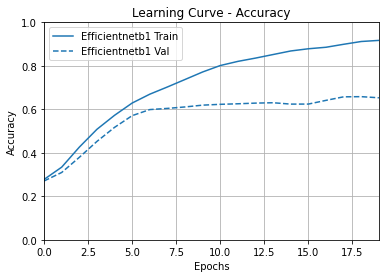

In [33]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plotter.plot(histories)
plt.title("Learning Curve - Accuracy") 
plt.ylim([0, 1])

(0.0, 20.0)

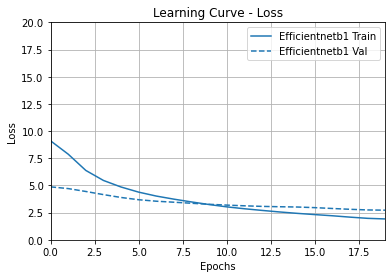

In [34]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)
plotter.plot(histories)
plt.title("Learning Curve - Loss") 
plt.ylim([0, 20])

In [35]:
pred=model.predict([X_test1, X_test2])
y_pred=[]
for p in pred:
  pred_index=np.argmax(p)
  y_pred.append(pred_index)
y_ture=[]
for p in y_test:
  pred_index=np.argmax(p)
  y_ture.append(pred_index)
y_true = np.array(y_ture)
y_pred = np.array(y_pred)

Text(0.5, 1.0, 'Confusion Matrix')

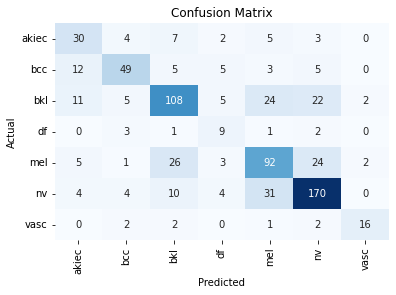

In [36]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
plt.xticks(np.arange(7)+0.5, labels, rotation= 90)
plt.yticks(np.arange(7)+0.5, labels, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix") 

In [37]:
clr = classification_report(y_true, y_pred, target_names=labels)
print("Classification Report:")
print("=====================================================")
print(clr)

Classification Report:
              precision    recall  f1-score   support

       akiec       0.48      0.59      0.53        51
         bcc       0.72      0.62      0.67        79
         bkl       0.68      0.61      0.64       177
          df       0.32      0.56      0.41        16
         mel       0.59      0.60      0.59       153
          nv       0.75      0.76      0.75       223
        vasc       0.80      0.70      0.74        23

    accuracy                           0.66       722
   macro avg       0.62      0.63      0.62       722
weighted avg       0.67      0.66      0.66       722



In [38]:
model.evaluate([X_test1, X_test2], y_test)

23/23 [==============================] - 1s 23ms/step - loss: 2.6639 - accuracy: 0.6565


[2.6638848781585693, 0.6565096974372864]